# Part 3, Topic 1: Large Hamming Weight Swings (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous part of the course, you saw that a microcontroller's power consumption changes based on what it's doing. In the case of a simple password check, this allowed us to see how many characters of the password we had correct, eventually resulting in the password being broken.*

*That attack was based on different code execution paths showing up differently in power traces. In this next set of labs, we'll posit that, not only does different instructions affect power consumption, the data being manipulated in the microcontroller also affects power consumption.*


**LEARNING OUTCOMES:**

* Using a power measurement to 'validate' a possible device model.
* Detecting the value of a single bit using power measurement.
* Breaking AES using the classic DPA attack.

## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).
* ☑ SCA101 Part 2 (you should understand how power consumption changes based on what code is being run)

## Power Trace Gathering

At this point you've got to insert code to perform the power trace capture. There are two options here:
* Capture from physical device.
* Read from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!


In [ ]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_SAM4S'
CRYPTO_TARGET = 'TINYAES128C'
SS_VER = 'SS_VER_2_1'

In [ ]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

In [ ]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../firmware/mcu/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3 -j

In [ ]:
cw.program_target(scope, prog, "../../../firmware/mcu/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

In [43]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 30
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    if text[0] & 0x01:
        text[0] = 0xFF
    else:
        text[0] = 0x00
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next() 

Capturing traces:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
%run "Lab 3_1 - Large Hamming Weight Swings (HARDWARE).ipynb"

INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
Blank crypto options, building for AES128
arm-none-eabi-gcc (15:13.2.rel1-2) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWNANO 
.
Welcome to another exciting ChipWhisperer target build!!
.
.
.
.
Compiling:
Compiling:
Compiling:
Compiling:
-en     simpleserial-aes.c ...
.
-en     .././simpleserial/simpleserial.c ...
-en     .././hal/hal.c ...
-en     .././hal//stm32f0_nano/stm32f0_hal_nano.c ...
Compiling:
-en     .././hal//stm32f0/stm32f0_hal_lowlevel.c ...
.
.
.
Compiling:
C

Capturing traces:   0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
assert len(trace_array) == 100
print("✔️ OK to continue!")

✔️ OK to continue!


## Grouping Traces

As we've seen in the slides, we've made an assumption that setting bits on the data lines consumes a measurable amount of power. Now, we're going test that theory by getting our target to manipulate data with a very high Hamming weight (0xFF) and a very low Hamming weight (0x00). For this purpose, the target is currently running AES, and it encrypted the text we sent it. If we're correct in our assumption, we should see a measurable difference between power traces with a high Hamming weight and a low one.

Currently, these traces are all mixed up. Separate them into two groups: `one_list` and `zero_list`. Here's an example of how we use the first byte to check for a 0x00, and assume if it's not that it's 0xFF. Here is a simple iteration to print them:

In [44]:
zero_list = []
one_list = []

for i in range(len(trace_array)):
    if textin_array[i][0] == 0x00:
        zero_list.append(trace_array[i])
    else:
        one_list.append(trace_array[i])

Now extend this to append them to two arrays, a `one_list` and a `zero_list`:

In [45]:
assert len(one_list) > len(zero_list)/2
assert len(zero_list) > len(one_list)/2

We should have two different lists. Whether we sent 0xFF or 0x00 was random, so these lists likely won't be evenly dispersed. Next, we'll want to take an average of each group (make sure you take an average of each trace at each point! We don't want an average of the traces in time), which will help smooth out any outliers and also fix our issue of having a different number of traces for each group.

The easiest way to accomplish this will be to use `np.mean()`, which can take a list as an argument. You'll need to specify the `axis` parameter as well, to ensure you take the correct dimension. Check the resulting size to make sure you still have traces of the same length as one input - the following block shows how you can verify that, assuming you used `one_avg` as the average.

In [46]:
trace_length = len(one_list[0])
one_avg = []
zero_avg = []

print("Traces had original sample length of %d"%trace_length)

one_avg = (np.mean(one_list, axis=0))
zero_avg = (np.mean(zero_list, axis=0))

if len(one_avg) != trace_length:
    raise ValueError("Average length is only %d - check you did correct dimensions!"%len(one_avg))

Traces had original sample length of 5000


Finally, subtract the two averages and plot the resulting data:

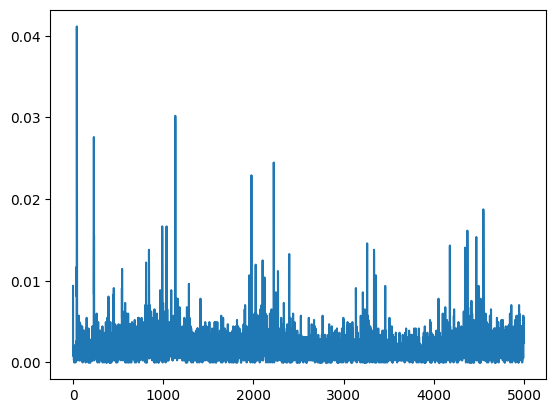

In [48]:
import matplotlib.pylab as plt
plt.plot(np.abs(one_avg - zero_avg))

You should see a very distinct trace near the beginning of the plot, meaning that the data being manipulated in the target device is visible in its power trace! Again, there's a lot of room to explore here:

* Try setting multiple bytes to 0x00 and 0xFF.
* Try using smaller hamming weight differences. Is the spike still distinct? What about if you capture more traces?
* We focused on the first byte here. Try putting the difference plots for multiple different bytes on the same plot.
* The target is running AES here. Can you get the spikes to appear in different places if you set a byte in a later round of AES (say round 5) to 0x00 or 0xFF?

One other note that might trip you out: rememeber you are measuring the voltage at the input to ChipWhisperer, which is measured across a shunt resistor. The end result of this is that a lower voltage actually means more power. So you might see the spikes flipped from the "expected" direction based on a 1 taking more power than a 0.

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>